# 2. Framework for PDE-based Bayesian inverse problems in CUQIpy (sections 2.1 to 2.6)

## 2.1. The 1D heat equation inverse problem

##  2.2 The discretized heat equation in CUQIpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.geometry import Continuous1D, KLExpansion, StepExpansion
from cuqi.pde import TimeDependentLinearPDE
from cuqi.model import PDEModel
from cuqi.sampler import CWMH
from cuqi.array import CUQIarray
from paper_figures import plot_figure2, plot_figure3, plot_figure4

/Users/amal/opt/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
n_grid = 100   # Number of solution nodes
h = 1/(n_grid+1)   # Space step size

In [3]:
grid = np.linspace(h, 1-h, n_grid)

In [4]:
tau_max = 0.02 # Final time
cfl = 5/11 # The cfl condition to have a stable solution
dt_approx = cfl*h**2 # Defining approximate time step size
n_tau = int(tau_max/dt_approx)+1 # Number of time steps

In [5]:
tau = np.linspace(0, tau_max, n_tau)

In [6]:
c = 1

In [7]:
f = np.zeros(n_grid)
D_c = c**2 * ( np.diag(-2*np.ones(n_grid), 0) +
np.diag(np.ones(n_grid-1), -1) +
np.diag(np.ones(n_grid-1), 1) ) / h**2

In [8]:
def PDE_form(g, tau_current):
    return (D_c, f, g)

In [9]:
PDE = TimeDependentLinearPDE(PDE_form, tau, grid_sol=grid)

In [10]:
print(PDE)

CUQI TimeDependentLinearPDE.
PDE form expression:
def PDE_form(g, tau_current):
    return (D_c, f, g)



In [11]:
g_custom =1/30*(1-np.cos(2*np.pi*(1-grid)/(1)))\
                +1/30*np.exp(-2*(10*(grid-0.5))**2)+\
                 1/30*np.exp(-2*(10*(grid-0.8))**2)

In [12]:
PDE.assemble(g_custom)
u_custom, info = PDE.solve()

In [13]:
y_custom = PDE.observe(u_custom)

Code cell for plotting figure 2:

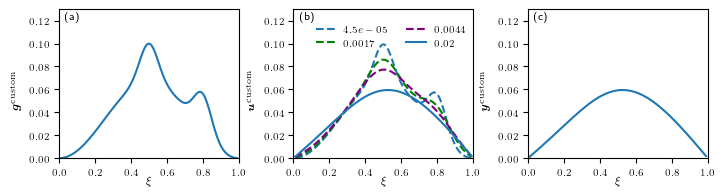

In [14]:
fig_dir = './figs/'
version = 'v3'

# Hack to show solutions at intermediate time steps
# In upcoming release, we will add this feature to the PDE class
# to return solutions at all time steps
intermediate_indices = [1, 39, 99, len(tau)-1]
intermediate_times = [tau[i] for i in intermediate_indices]
u_intermediate = np.zeros((len(intermediate_indices), len(grid)))

for i, idx in enumerate(intermediate_indices):
    PDE_temp = TimeDependentLinearPDE(
        PDE.PDE_form, tau[:idx+1], grid_sol=grid)
    PDE_temp.assemble(g_custom)
    u_intermediate[i, :] = PDE_temp.solve()[0]

plot_figure2(fig_dir, version,
             g_custom, u_custom, y_custom, u_intermediate,
             grid, tau, intermediate_times)

## 2.3 The 1D heat forward problem in CUQIpy

In [15]:
G_cont = Continuous1D(grid)

In [16]:
A = PDEModel(PDE, range_geometry=G_cont, domain_geometry=G_cont)

## 2.4 Parametrization by the geometry class

In [17]:
n_step = 3

In [18]:
G_step = StepExpansion(grid, n_steps=n_step)

In [19]:
x_step = CUQIarray([0, 1, 0.5], geometry=G_step)

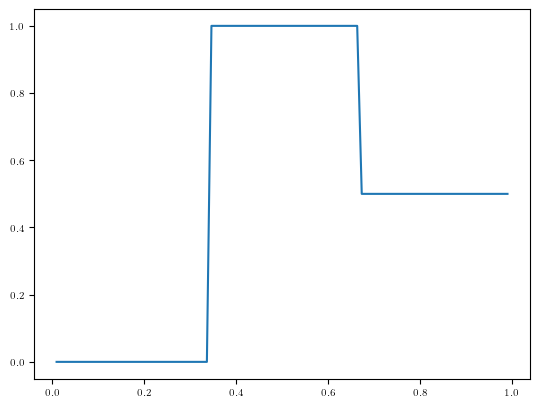

In [20]:
x_step.plot()

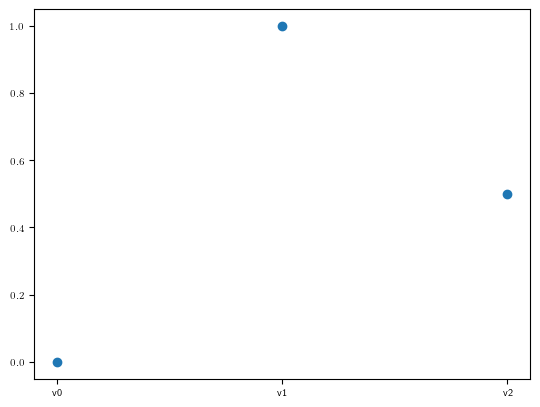

In [21]:
x_step.plot(plot_par=True)

In [22]:
A = PDEModel(PDE, range_geometry=G_cont, domain_geometry=G_step)

In [23]:
print(A)

CUQI PDEModel: StepExpansion(3,) -> Continuous1D(100,).
    Forward parameters: ['x'].
    PDE: TimeDependentLinearPDE.


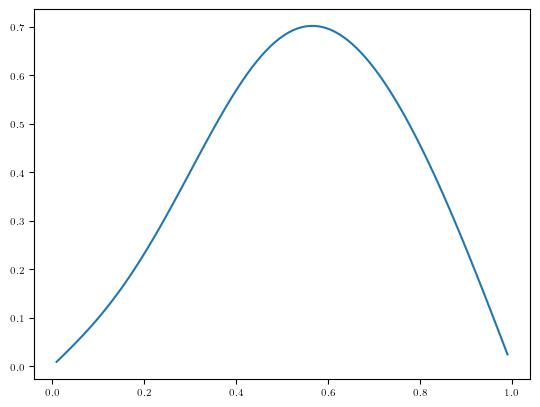

In [24]:
y_step = A(x=x_step)
y_step.plot()

Code cell for plotting figure 3:

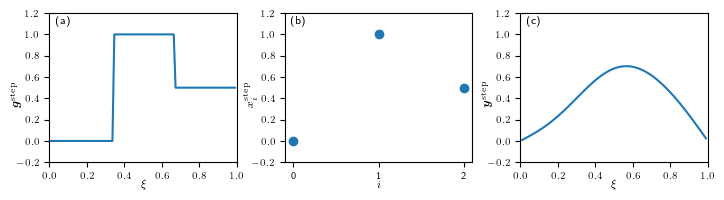

In [25]:
fig_dir = './figs/'
version = 'v3'
plot_figure3(fig_dir, version, x_step, y_step)

## 2.5. Specifying and solving the PDE-based Bayesian inverse problem

In [26]:
# set up the noise level:
noise_level = 0.1
s_noise =1.0/np.sqrt(n_grid)* noise_level*np.linalg.norm(y_step)

In [27]:
x = Gaussian(np.zeros(n_step), 1, geometry=G_step)
y = Gaussian(A(x), s_noise**2, geometry=G_cont)

In [28]:
print(y)

CUQI Gaussian. Conditioning variables ['x'].


In [29]:
prior_samples = x.sample(5)

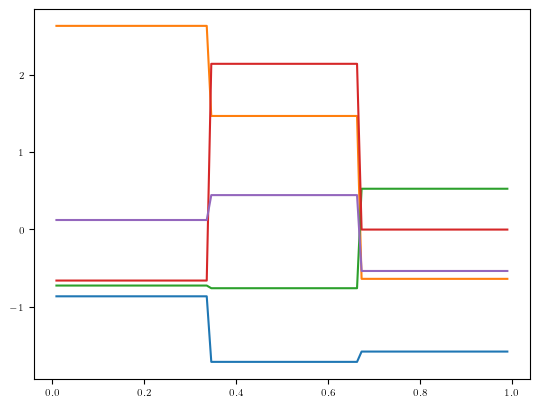

In [30]:
# The cell should be replaced by the following code line in an upcoming release
# prior_samples.plot()
# Using prior_samples.plot is supported in general but there is a bug in this
# case.

# Hack for plotting the prior samples
for s in prior_samples:
    prior_samples.geometry.plot(s, is_par=True) 


In [31]:
y_obs = y(x=x_step).sample()

In [32]:
joint = JointDistribution(x, y)
posterior = joint(y=y_obs) # condition on y=y_obs

In [33]:
print(joint)

JointDistribution(
    Equation: 
	p(x,y) = p(x)p(y|x)
    Densities: 
	x ~ CUQI Gaussian.
	y ~ CUQI Gaussian. Conditioning variables ['x'].
)


In [34]:
my_sampler = CWMH(posterior)

In [35]:
# The factor to reduce the number of samples just to make the code
# run faster, setting it to 1 will give the same results as in the paper
# up to some random effect due to the random sampling and noise
Ns_factor = 1  

posterior_samples = my_sampler.sample_adapt(int(50000*Ns_factor))


Sample 50000 / 50000

Average acceptance rate all components: 0.047286666666666664 



## 2.6. Posterior samples analysis, and visualization

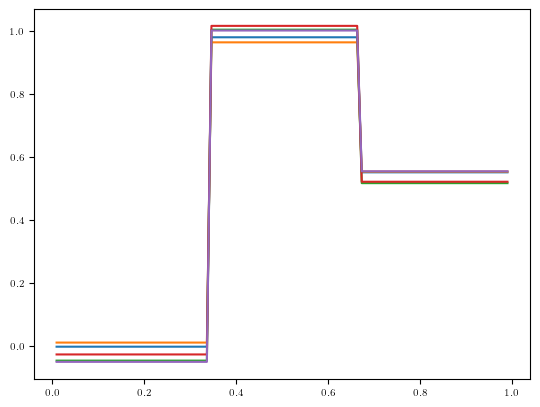

In [36]:
# The cell should be replaced by the following code line in an upcoming release
# posterior_samples.plot([int(idx*Ns_factor) for idx in [2000, 3000, 4000, 5000, 6000]])
# Using posterior_samples.plot is supported in general but there is a bug in this
# case.

# Hack for plotting the prior samples
samples_indices = [int(idx*Ns_factor) for idx in [2000, 3000, 4000, 5000, 6000]]
for idx in samples_indices:
    posterior_samples.geometry.plot(posterior_samples.samples[:,idx], is_par=True) 

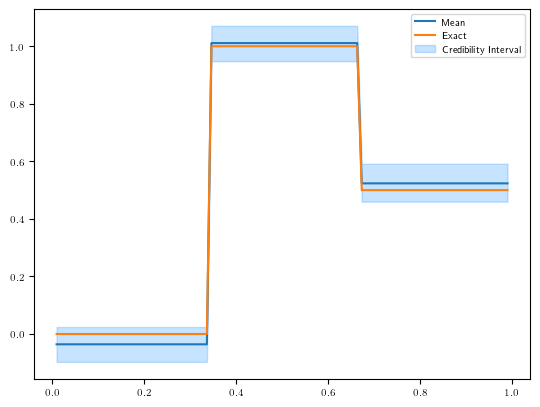

In [37]:
posterior_samples.plot_ci(95, exact=x_step)

Code cell for plotting figure 4:

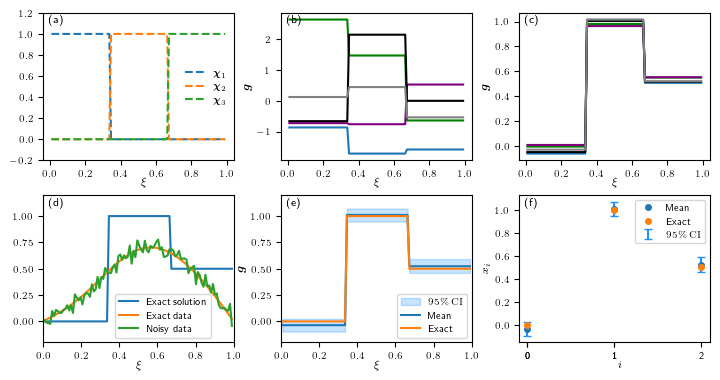

In [38]:
fig_dir = './figs/'
version = 'v6'
plot_figure4(fig_dir, version, G_step, 
                 prior_samples, posterior_samples, Ns_factor,
                 x_step, y_step, y_obs)